# Copyright Netherlands eScience Center <br>
**Function     : Evaluate the structure complexity and its influence of BayesianLSTM** <br>
**Author       : Yang Liu** <br>
**First Built  : 2021.05.08** <br>
**Last Update  : 2021.05.08** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to insepct the effectiveness of increasing the complexity of the network.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append("../")
sys.path.append("H:\\Creator_Zone\\Script_craft\\ML4Climate\\Scripts\\DLACs")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# datapath for output
output_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\paperFig\\review'
# data path of experiment
path_VAR = 'H:\\Creator_Zone\\Paper\\Bayesian_Lorenz_paper\\data_paper'
path_p100000_layer3 = 'H:\\Creator_Zone\\Paper\\Bayesian_Lorenz_paper\\data_paper'
path_p100000_layer5 = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx4_layer5'
path_p1000000_layer7 = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p1000000_stdx4_layer7'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>

In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

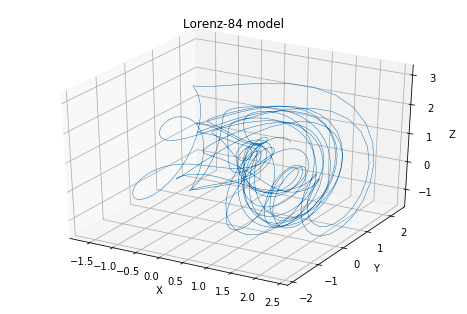

<Figure size 432x288 with 0 Axes>

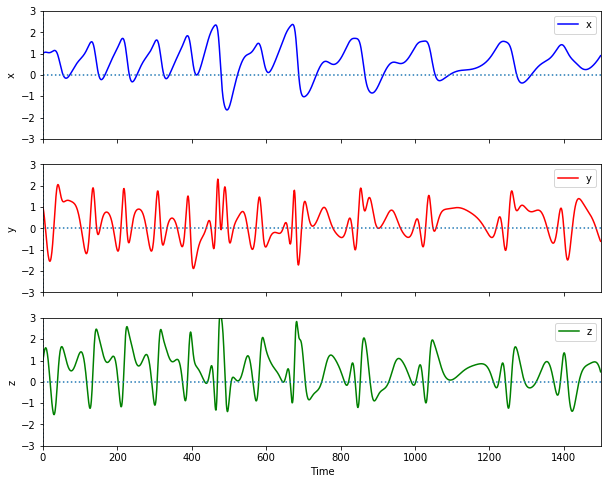

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std
    x_std = np.std(x)
    y_std = np.std(y)
    z_std = np.std(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


# Postprocess forecast data <br>
** Postprocess and visualization of ensemble forecast data ** <br>

In [12]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 60 # unit week
    # number of ensembles
    predictand_VAR = np.zeros((3, test_len, step_lead), dtype=float)
    predictand_p100000_layer3 = np.zeros((3, test_len, step_lead), dtype=float)
    predictand_p100000_layer5 = np.zeros((3, test_len, step_lead), dtype=float)
    #predictand_p1000000_layer7 = np.zeros((3, test_len, step_lead), dtype=float)
    
    dataset_VAR = Dataset(os.path.join(path_VAR, 'VAR_pred_lorenz84_ens_member_4.nc'))
    dataset_p100000_layer3 = Dataset(os.path.join(path_p100000_layer3,'BayesLSTM_pred_lorenz84_ens_member_4.nc'))
    dataset_p100000_layer5 = Dataset(os.path.join(path_p100000_layer5,'pred_lorenz84_ens_4.nc'))
    #dataset_p1000000_layer7 = Dataset(os.path.join(path_p1000000_layer7,'pred_lorenz84_ens_4.nc'))
    
    predictand_VAR[:] = dataset_VAR.variables['series'][:,:,:step_lead]
    predictand_p100000_layer3[:] = dataset_p100000_layer3.variables['series'][:,:,:step_lead]
    predictand_p100000_layer5[:] = dataset_p100000_layer5.variables['series'][:,:,:step_lead]

    print(predictand_VAR.shape)
    print(predictand_p100000_layer3.shape)
    print(predictand_p100000_layer5.shape)

*******************  load ensemble data  *********************
(3, 200, 60)
(3, 200, 60)
(3, 200, 60)


In [13]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [15]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # RMSE
    def RMSE(obs, pred):
        """
        Root Mean Square Error.
        """
        rmse = np.sqrt(np.mean((obs - pred)**2))
        
        return rmse
    
    # lead time dependent RMSE of Bayesian LSTM forecast
    rmse_VAR = np.zeros((step_lead+1, 3), dtype=float)
    rmse_predictand_p100000_layer3 = np.zeros((step_lead+1, 3), dtype=float)
    rmse_predictand_p100000_layer5 = np.zeros((step_lead+1, 3), dtype=float)
    
    for i in range(step_lead):
        rmse_x_VAR = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_VAR[0,:,i])
        rmse_y_VAR = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_VAR[1,:,i])
        rmse_z_VAR = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_VAR[2,:,i])
            
        rmse_x_predictand_p100000_layer3 = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_p100000_layer3[0,:,i] * (x_max - x_min) + x_min)
        rmse_y_predictand_p100000_layer3 = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_p100000_layer3[1,:,i] * (y_max - y_min) + y_min)
        rmse_z_predictand_p100000_layer3 = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_p100000_layer3[2,:,i] * (z_max - z_min) + z_min)
        
        rmse_x_predictand_p100000_layer5 = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_p100000_layer5[0,:,i] * (x_max - x_min) + x_min)
        rmse_y_predictand_p100000_layer5 = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_p100000_layer5[1,:,i] * (y_max - y_min) + y_min)
        rmse_z_predictand_p100000_layer5 = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_p100000_layer5[2,:,i] * (z_max - z_min) + z_min)
            
        rmse_VAR[i+1,0] = rmse_x_VAR
        rmse_VAR[i+1,1] = rmse_y_VAR
        rmse_VAR[i+1,2] = rmse_z_VAR
            
        rmse_predictand_p100000_layer3[i+1,0] = rmse_x_predictand_p100000_layer3
        rmse_predictand_p100000_layer3[i+1,1] = rmse_y_predictand_p100000_layer3
        rmse_predictand_p100000_layer3[i+1,2] = rmse_z_predictand_p100000_layer3
        
        rmse_predictand_p100000_layer5[i+1,0] = rmse_x_predictand_p100000_layer5
        rmse_predictand_p100000_layer5[i+1,1] = rmse_y_predictand_p100000_layer5
        rmse_predictand_p100000_layer5[i+1,2] = rmse_z_predictand_p100000_layer5

<Figure size 432x288 with 0 Axes>

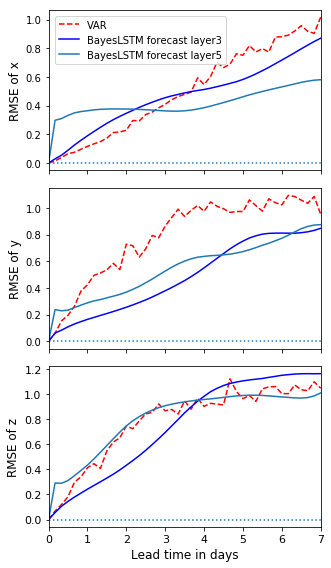

In [19]:
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################  
    display_upto = 42
        
    index = np.arange(0, step_lead)
    
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(4.8, 8, forward=True)
    
    # rmse of forecast
    ax1.plot(np.arange(display_upto+1), rmse_VAR[:display_upto+1,0], color='r', linestyle='dashed', label='VAR')
    ax1.plot(np.arange(display_upto+1), rmse_predictand_p100000_layer3[:display_upto+1,0], 'b', label='BayesLSTM forecast layer3')
    ax1.plot(np.arange(display_upto+1), rmse_predictand_p100000_layer5[:display_upto+1,0], color=colormap[0], label='BayesLSTM forecast layer5')
    
    ax2.plot(np.arange(display_upto+1), rmse_VAR[:display_upto+1,1], color='r', linestyle='dashed', label='VAR')
    ax2.plot(np.arange(display_upto+1), rmse_predictand_p100000_layer3[:display_upto+1,1], 'b', label='BayesLSTM forecast layer3')
    ax2.plot(np.arange(display_upto+1), rmse_predictand_p100000_layer5[:display_upto+1,1], color=colormap[0], label='BayesLSTM forecast layer5')
    
    ax3.plot(np.arange(display_upto+1), rmse_VAR[:display_upto+1,2], color='r', linestyle='dashed', label='VAR')
    ax3.plot(np.arange(display_upto+1), rmse_predictand_p100000_layer3[:display_upto+1,2], 'b', label='BayesLSTM forecast layer3')    
    ax3.plot(np.arange(display_upto+1), rmse_predictand_p100000_layer5[:display_upto+1,2], color=colormap[0], label='BayesLSTM forecast layer5')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    ax1.set_xticks(np.arange(0,display_upto+1,3))
    ax2.set_xticks(np.arange(0,display_upto+1,3))
    ax3.set_xticks(np.arange(0,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x", fontsize=12)
    ax2.set_ylabel("RMSE of y", fontsize=12)
    ax3.set_ylabel("RMSE of z", fontsize=12)
    
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1),fontsize=11)
    plt.yticks(fontsize=11)    
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.005,0.995), prop={'size': 10.0}, loc=2)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.995,0.03), prop={'size': 10.0}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig04.savefig(os.path.join(output_path,'rmse_bayes_forecast_complexStruc.png'),dpi=150)